<a href="https://colab.research.google.com/github/Soilverts/face-recognization/blob/main/prj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation,MaxPooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load DataSet

In [3]:
df = pd.read_csv('/content/drive/MyDrive/539/fer2013.csv')
print("shape:", df.shape)
df.head()

shape: (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


The 1st column is emotion, it has 7 kinds of value, indicate 7 kinds of emotion.

The 2nd column is an 2304 array, indicate a 48 x 48 image

The 3rd column is usage

In this project, we only care about 1st and 2nd columns


### data overview

total pixel of image: 2304


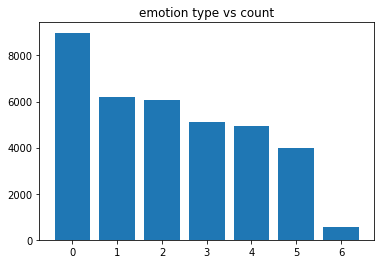

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
print("total pixel of image:", len(df.pixels[0].split(' ')))
df.emotion.value_counts()
plt.bar(range(7), df.emotion.value_counts().values)
plt.title("emotion type vs count")
plt.show()

### convert data into numpy array

In [5]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis=0)
print(img_array.shape)
img_features = []
for i in range(len(img_array)):
    img_features.append(cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB))
    
# convert 1-D image to 3-D image
img_features = np.array(img_features) / 255
print(img_features.shape)


(35887, 48, 48)
(35887, 48, 48, 3)


### show some of the image

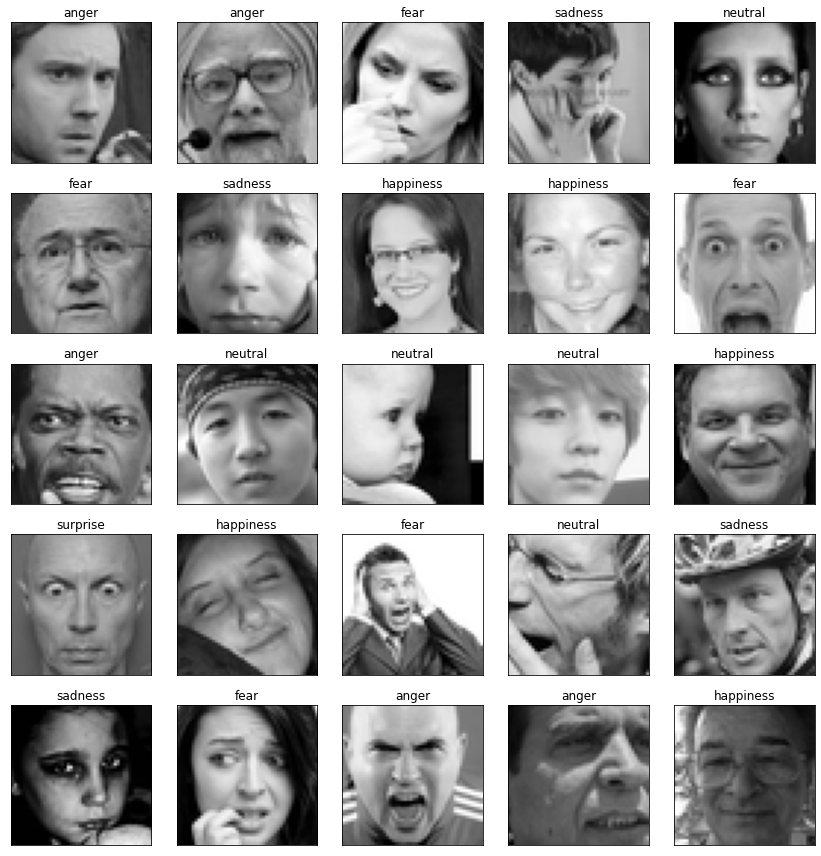

In [6]:
plt.figure(1, (12, 12))
for j in range(25):
    ax = plt.subplot(5, 5, j + 1)
    ax.imshow(img_features[j], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[df.emotion[j]])
    plt.tight_layout()

### one hot the label

In [7]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
print(img_labels.shape)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

(35887, 7)
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### save data into npy format

In [8]:
np.savez("fac", img_features=img_features, img_labels=img_labels)

=====================================================================================================

### load npy data

(35887, 48, 48, 3)
(35887, 7)


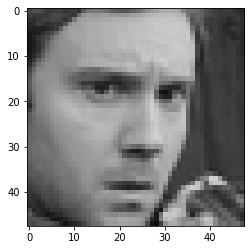

In [9]:
ar = np.load("fac.npz")
img_features, img_labels = ar["img_features"], ar["img_labels"]

print(img_features.shape)
print(img_labels.shape)

plt.imshow(img_features[0])


### Split into train data and test data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    img_features, img_labels,shuffle=True, 
    stratify=img_labels,test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32298, 48, 48, 3) (3589, 48, 48, 3) (32298, 7) (3589, 7)


In [11]:
# del df
# del img_features
# del img_labels


In [12]:
_, img_width, img_height, img_depth = X_train.shape
_, num_classes = y_train.shape


## 2. Create data flow

In [13]:
# data prep
datagen = ImageDataGenerator(
    rotation_range=10,
#     zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')
datagen = ImageDataGenerator()

# .flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')
train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=128)

validation_generator = datagen.flow(
    X_test,
    y_test,
    batch_size=128)

# show 3 piece of data
for i in range(3):
    xs,ys = next(validation_generator)
    print(xs.shape)
    print(ys.shape)
    print()

(128, 48, 48, 3)
(128, 7)

(128, 48, 48, 3)
(128, 7)

(128, 48, 48, 3)
(128, 7)



## 3. Prepare for Model

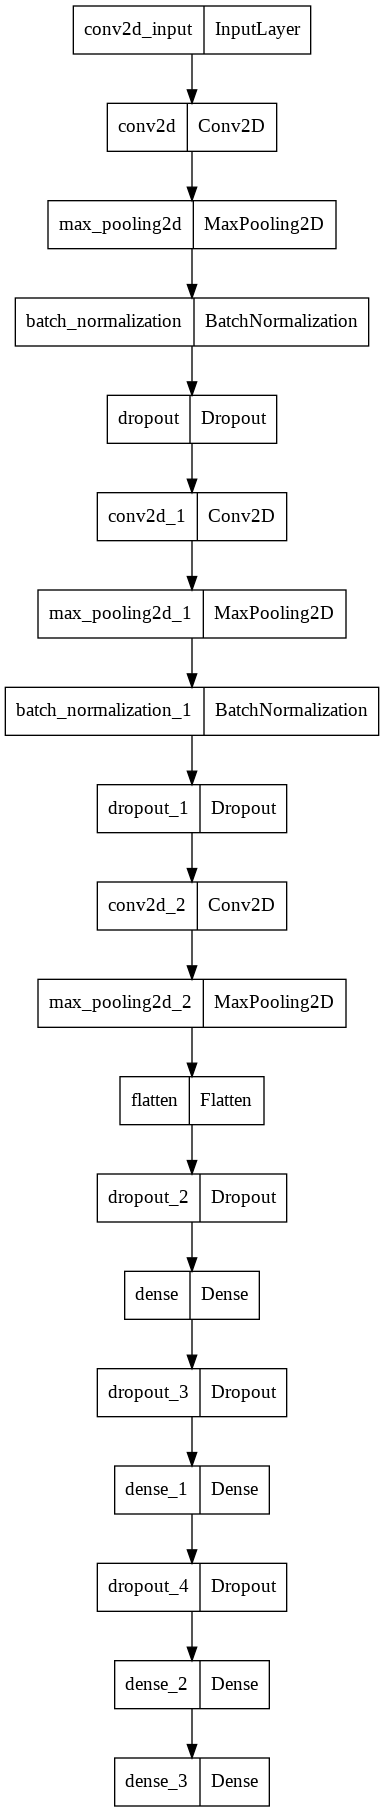

In [14]:
model = tf.keras.models.Sequential([
    
    # filter the image for 1st time
    Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same',input_shape=(48,48,3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(0.4),
    
    # filter the image for 2nd time
    Conv2D(128, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(0.4),
    
    # filter the image for 3rd time
    Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
    Flatten(),
    Dropout(0.3),
    
    Dense(2048, activation='relu'),
    Dropout(0.4),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer = optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model)

# 4. Train the model

In [15]:
history=model.fit(
    train_generator,
    steps_per_epoch=250,
    epochs=70,
    validation_data=validation_generator,
    validation_steps=25
)

Epoch 1/70
250/250 [==============================] - 19s 28ms/step - loss: 1.9875 - accuracy: 0.2280 - val_loss: 1.8397 - val_accuracy: 0.2481
Epoch 2/70
250/250 [==============================] - 7s 27ms/step - loss: 1.7591 - accuracy: 0.2888 - val_loss: 1.7430 - val_accuracy: 0.2837
Epoch 3/70
250/250 [==============================] - 7s 28ms/step - loss: 1.6489 - accuracy: 0.3493 - val_loss: 1.5996 - val_accuracy: 0.3803
Epoch 4/70
250/250 [==============================] - 7s 27ms/step - loss: 1.5776 - accuracy: 0.3830 - val_loss: 1.5371 - val_accuracy: 0.4112
Epoch 5/70
250/250 [==============================] - 7s 26ms/step - loss: 1.5215 - accuracy: 0.4072 - val_loss: 1.4765 - val_accuracy: 0.4400
Epoch 6/70
250/250 [==============================] - 7s 26ms/step - loss: 1.4800 - accuracy: 0.4235 - val_loss: 1.5891 - val_accuracy: 0.3934
Epoch 7/70
250/250 [==============================] - 7s 27ms/step - loss: 1.4360 - accuracy: 0.4449 - val_loss: 1.3833 - val_accuracy: 0.472

In [16]:
# model.save("net.h5")
# model = tf.keras.models.load_model("net.h5")

## 5. Evaluate

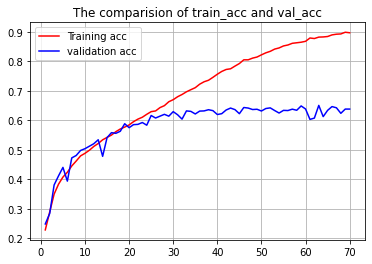

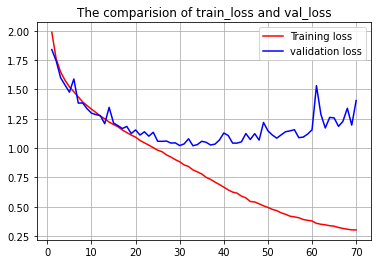

In [17]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
 
epochs=range(1,len(acc)+1)
plt.figure("acc")
plt.plot(epochs,acc,'r-',label='Training acc')
plt.plot(epochs,val_acc,'b',label='validation acc')
plt.title('The comparision of train_acc and val_acc')
plt.legend()
plt.grid(True)
plt.show()
 
plt.figure("loss")
plt.plot(epochs,loss,'r-',label='Training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title('The comparision of train_loss and val_loss')
plt.legend()
plt.grid(True)
plt.show()
